<a href="https://www.spe.org/events/en/2022/conference/22apog/asia-pacific-oil-and-gas-conference-and-exhibition.html"><img src = "https://www.spe.org/binaries/content/gallery/specms/speevents/organization-logos/spe-logo-2020.png" width = 200> 

<h1 align=center><font size = 5>Prediction of Recovery Factor using Machine Learning Methods</font></h1>

<h1 align=center><font size = 4> Munish Kumar, Kannapan Swaminathan</font></h1>
<h1 align=center><font size = 4> Part 4: Modelling of Recovery Factor</font></h1>
<h1 align=center><font size = 3> ERCE 2022 </font></h1>

###### References

1. https://www.kaggle.com/code/kkhandekar/an-introduction-to-pycaret/notebook.
2. https://towardsdatascience.com/5-things-you-dont-know-about-pycaret-528db0436eec
3. https://www.dataquest.io/blog/understanding-regression-error-metrics/ 
4. https://www.analyticsvidhya.com/blog/2021/07/automl-using-pycaret-with-a-regression-use-case/
5. https://www.datacamp.com/community/tutorials/guide-for-automating-ml-workflows-using-pycaret
6. https://pycaret.readthedocs.io/en/latest/api/regression.html
7. http://www.pycaret.org/tutorials/html/REG102.html
8. https://githubhelp.com/ray-project/tune-sklearn

#### Libraries

In [1]:
# Only install the following libraries if you dont have it, otherwise leave it commented out

#!conda install -c anaconda natsort --yes
#!conda install -c anaconda xlrd --yes
#!pip install pycaret[full] --user
#!pip install mlflow --user
#!pip install tune-sklearn ray[tune] --user
#!pip install optuna -- user
#!pip install hyperopt --user

# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import time
import re
import requests
import pickle
import seaborn as sns
import os
import glob
import sys
from natsort import natsorted
sns.set()

import plotly.graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# Sklearn Liraries
from sklearn import preprocessing

import datetime
from datetime import timedelta, date 
start = time.time()
%matplotlib inline

from ray import tune

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
print('Libraries imported')

Libraries imported


###### Declare some global variables

In [2]:
#Receive Data
#dir_name = r'C:\Users\kswaminathan\OneDrive\01_KannaLibrary\15_Analogs'
dir_name = r'C:\Users\mkumar\Documents\GitHub\SPE_Paper\Final'
filename_suffix = 'csv'

##### Read in the data 

In [3]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
df = pd.read_excel("dfssoil.xlsx", thousands=',', skiprows = skiprows)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')] 
df.head()

,10_Region,11_Basin name,52_Well spacing (average) (ac),72_Onshore or offshore,75_Temperature (original) (deg. F),77_Pressure (original) (psi),82_Drive mechanism (main),117_Reservoir top subsea depth (ft TVDSS),118_Structural flank dip (average) (deg.),149_Reservoir period,...,161_Reservoir architecture (main),176_Net/gross ratio (average),204_Porosity (matrix average) (%),210_Permeability (air average) (mD),218_API gravity (average) (deg. API),225_Viscosity (oil average) (cp),252_GOR (initial average) (SCF/STB),293_Original in-place oil equivalent (MMBOE),307_Recovery factor (ultimate oil) (%),EORIOR
0,AFRICA,ABU GHARADIG,140.0,ONSHORE,232.0,4500.000000,GAS DRIVE,9350.0,15.0,CRETACEOUS,...,JIGSAW-PUZZLE,0.10,21.0,140.00,40.5,13.810000,850.0,166.0,19.0,2
1,AFRICA,ABU GHARADIG,140.0,ONSHORE,250.0,4600.000000,GAS DRIVE,9650.0,15.0,CRETACEOUS,...,JIGSAW-PUZZLE,0.07,16.0,140.00,40.0,4.740000,800.0,214.0,14.0,2
2,MIDDLE EAST,ZAGROS,0.0,ONSHORE,190.0,4452.278385,AQUIFER DRIVE,7500.0,20.0,NEOGENE/PALEOGENE,...,LAYER-CAKE,0.36,19.0,385.00,32.6,0.580000,950.0,57300.0,44.3,3
3,MIDDLE EAST,SOUTH OMAN SALT,62.0,ONSHORE,212.0,11600.000000,GAS DRIVE,12140.0,10.0,CAMBRIAN/PROTEROZOIC,...,LAYER-CAKE,0.68,17.0,0.01,48.0,0.135469,410.0,1321.0,7.0,4
4,EUROPE,NORTH SEA CENTRAL,0.0,OFFSHORE,172.0,2850.000000,GAS DRIVE,6102.0,1.5,PALEOGENE,...,TANK LIKE,0.80,35.0,3000.00,19.5,7.000000,246.0,1000.0,44.0,7


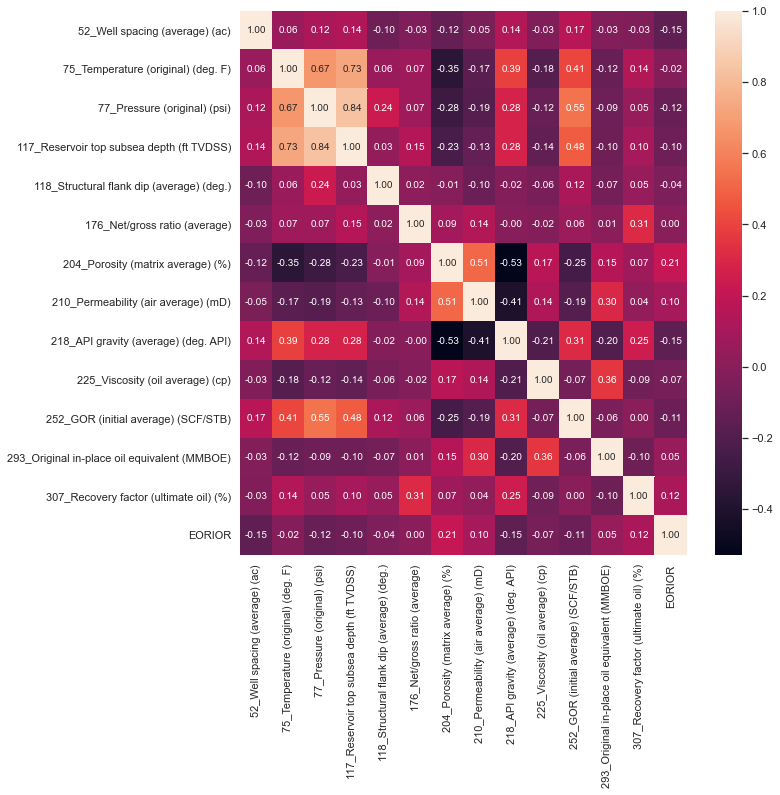

In [4]:
# Plot as Heat map to check for highly correlated variables
plt.figure(figsize=(10, 10))
ax = sns.heatmap(df.corr(), annot=True, fmt=".2f")

In observing the heat map above, I define highly correlated variables as having collinearity coeeficients of > 0.7. Therefore,

1. 75_ Temperature is highly correlatable to 117_Reservoir top subsea depth
2. 77_Pressure is highly correlatable to  117_Reservoir top subsea depth

As high collinear variables do not add any additional information when it comes to predictive modelling, I will drop "117_Reservoir top subsea depth" and recreate the heat map to check for correlation.

Note that dropping the variables makes sense, as reservoir top subsea depth should be physically linked to pressure and temperature in a reservoir

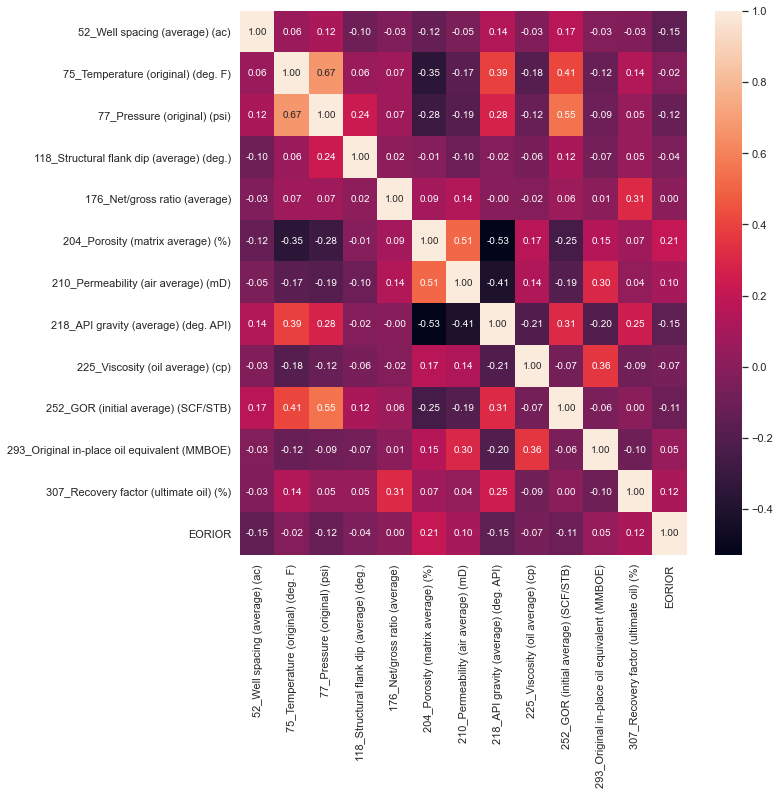

In [5]:
df_drop = df.drop(['117_Reservoir top subsea depth (ft TVDSS)',
                  ], axis = 1)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(df_drop.corr(), annot=True, fmt=".2f")

##### Drop Structural Flank Dip - does not make much difference to the results and is a difficult input to find for fields

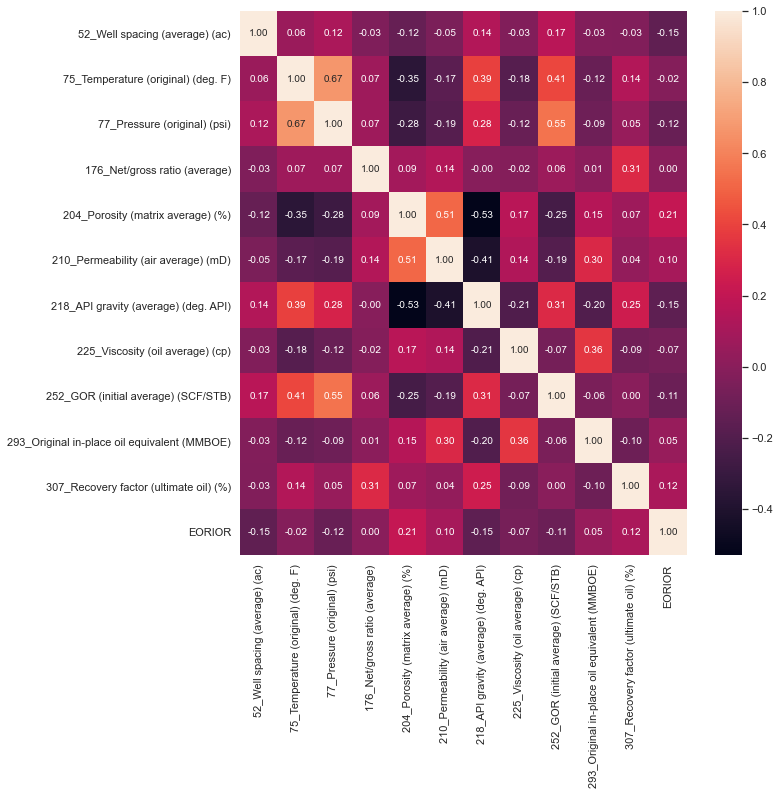

In [6]:
df_drop = df_drop.drop(['118_Structural flank dip (average) (deg.)',
                  ], axis = 1)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(df_drop.corr(), annot=True, fmt=".2f")

##### Convert EORIOR to float - to ensure it is a numerical feature

In [7]:
df_drop['EORIOR'] = df_drop['EORIOR'].astype(float)

In [8]:
# Confirm properties of final dataframe
print(len(df_drop))
print(df_drop.info())
print(df_drop.describe(include='all'))
print(df_drop.columns.values)

436
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 19 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   10_Region                                     436 non-null    object 
 1   11_Basin name                                 436 non-null    object 
 2   52_Well spacing (average) (ac)                436 non-null    float64
 3   72_Onshore or offshore                        436 non-null    object 
 4   75_Temperature (original) (deg. F)            436 non-null    float64
 5   77_Pressure (original) (psi)                  436 non-null    float64
 6   82_Drive mechanism (main)                     436 non-null    object 
 7   149_Reservoir period                          436 non-null    object 
 8   153_Depositional system (main)                436 non-null    object 
 9   161_Reservoir architecture (main)             436 non-null   

#### Pycaret Implementation

Pycaret will be used in the machine learning portion. Pycaret is a low-code machine learning library in Python that automates machine learning workflows. One of its key benefits is its ability to run a large number of differnt machine learning algorithms, but with only a few lines of code

In [9]:
from pycaret.regression import *

#Create a copy
model_df = df_drop.copy()
target = '307_Recovery factor (ultimate oil) (%)'

# no resampling
clf_none = setup(
            data=model_df,
            target=target,
            session_id=42,
            normalize=True,
            ignore_low_variance=True,
            train_size=0.7)

,Description,Value
0,session_id,42
1,Target,307_Recovery factor (ultimate oil) (%)
2,Original Data,"(436, 19)"
3,Missing Values,False
4,Numeric Features,11
5,Categorical Features,7
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(305, 154)"


In [10]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,8.8658,125.0359,11.1468,0.4177,0.3442,0.3201,1.0430
rf,Random Forest Regressor,9.3928,135.1021,11.6123,0.3694,0.3576,0.3371,0.0950
gbr,Gradient Boosting Regressor,9.6589,141.3729,11.8708,0.3378,0.3638,0.3435,0.0360
xgboost,Extreme Gradient Boosting,9.4470,144.1076,11.9662,0.3202,0.3627,0.3234,0.1240
ada,AdaBoost Regressor,9.8921,146.6899,12.0955,0.3127,0.3761,0.3683,0.0340
lightgbm,Light Gradient Boosting Machine,9.9070,147.3030,12.1090,0.3106,0.3633,0.3463,0.1960
et,Extra Trees Regressor,10.3469,163.1655,12.7459,0.2390,0.3918,0.3740,0.0980
br,Bayesian Ridge,10.7803,173.3774,13.1362,0.1943,0.4022,0.3977,0.0140
knn,K Neighbors Regressor,10.8706,176.8327,13.2565,0.1772,0.4131,0.4080,0.0100
lasso,Lasso Regression,11.1737,184.7241,13.5774,0.1399,0.4180,0.4212,0.0080


In [11]:
top3 = compare_models(include=['rf', 'gbr', 'catboost'], sort='MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,8.8658,125.0359,11.1468,0.4177,0.3442,0.3201,0.9900
rf,Random Forest Regressor,9.3928,135.1021,11.6123,0.3694,0.3576,0.3371,0.1010
gbr,Gradient Boosting Regressor,9.6589,141.3729,11.8708,0.3378,0.3638,0.3435,0.0370


### Plot each Model and Check Features

##### Category Boosting (CatBoost)

In [28]:
cb = create_model('catboost')
cb_results = pull()
#print(cb_results)

import pandas as pd
cb_feature_imp = pd.DataFrame({'Feature': get_config('X_train').columns, 'Value' : abs(cb.feature_importances_)}).sort_values(by='Value', ascending=False)
#print(cb_feature_imp)
cb_feature_imp.to_csv('Featue_importance_CATBOOST.csv')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,8.7774,143.7698,11.9904,0.3290,0.4423,0.4321
1,7.1289,96.1058,9.8034,0.5254,0.2974,0.2469
2,9.7137,139.7118,11.8200,0.3389,0.4119,0.4119
3,9.4459,162.8558,12.7615,0.3031,0.3707,0.3206
4,8.1459,113.1566,10.6375,0.4653,0.2931,0.2522
5,8.5145,101.7543,10.0873,0.5682,0.3716,0.3609
6,8.7495,122.0168,11.0461,0.4718,0.2692,0.2302
7,8.7297,110.2910,10.5020,0.3684,0.3032,0.2768
8,9.4621,121.1993,11.0091,0.4277,0.3276,0.3173
9,9.9906,139.4974,11.8109,0.3789,0.3553,0.3518


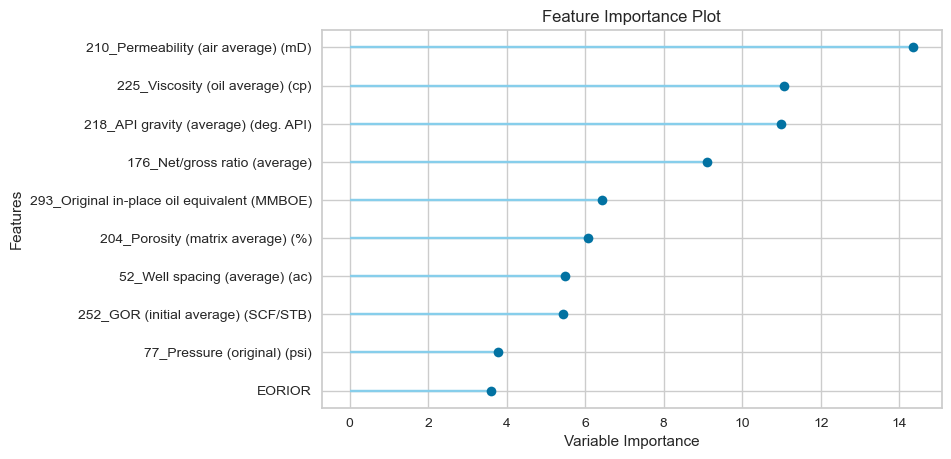

In [17]:
# Given the sheer number of variables, will only plot the first 10
plot_model(cb, plot = 'feature')

##### Random Forest (RFR)

In [18]:
rfr = create_model('rf')
rfr_results = pull()

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,9.1114,135.2387,11.6292,0.3689,0.4158,0.3989
1,9.0111,130.6803,11.4316,0.3546,0.3296,0.2945
2,9.6606,141.5488,11.8974,0.3302,0.4234,0.4284
3,9.1564,140.8654,11.8687,0.3972,0.3636,0.3357
4,8.8310,130.1396,11.4079,0.3850,0.3148,0.2785
5,9.7976,124.7850,11.1707,0.4705,0.3944,0.4059
6,9.0411,132.9739,11.5314,0.4243,0.2734,0.2265
7,8.6972,114.5386,10.7023,0.3441,0.3180,0.2870
8,10.9339,162.7236,12.7563,0.2316,0.3677,0.3542
9,9.6878,137.5266,11.7272,0.3877,0.3748,0.3617


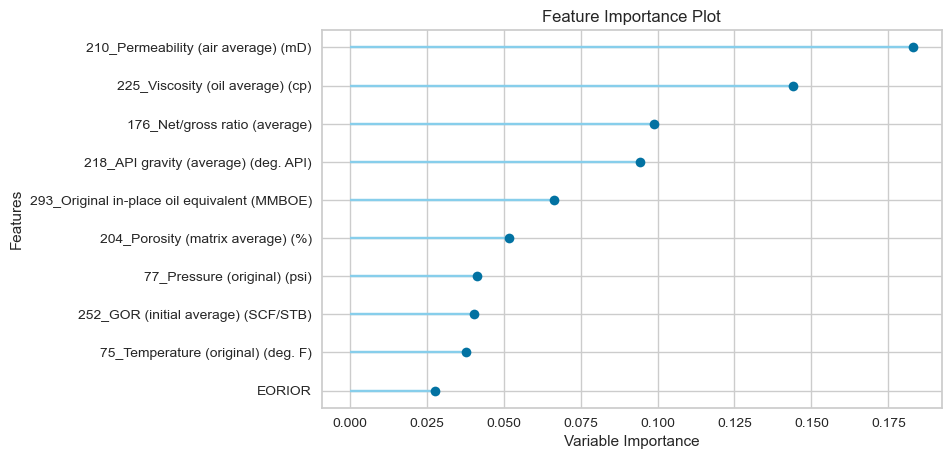

In [19]:
plot_model(rfr, plot = 'feature')

##### Gradient Boosting (GBR)

In [14]:
gbr = create_model('gbr')
gbr_results = pull()
#print(gbr_results)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,9.5535,151.0181,12.2889,0.2952,0.4355,0.4276
1,8.7608,115.4462,10.7446,0.4299,0.3173,0.2912
2,9.6868,152.7776,12.3603,0.2771,0.4282,0.4189
3,8.5895,148.1668,12.1724,0.3659,0.3530,0.2850
4,8.6990,126.0041,11.2252,0.4045,0.3112,0.2778
5,9.4480,121.1348,11.0061,0.4860,0.3828,0.3834
6,9.8464,130.8128,11.4373,0.4337,0.2900,0.2636
7,10.3484,145.2470,12.0518,0.1682,0.3548,0.3374
8,11.3218,161.8410,12.7217,0.2358,0.3671,0.3651
9,10.3350,161.2802,12.6996,0.2819,0.3983,0.3846


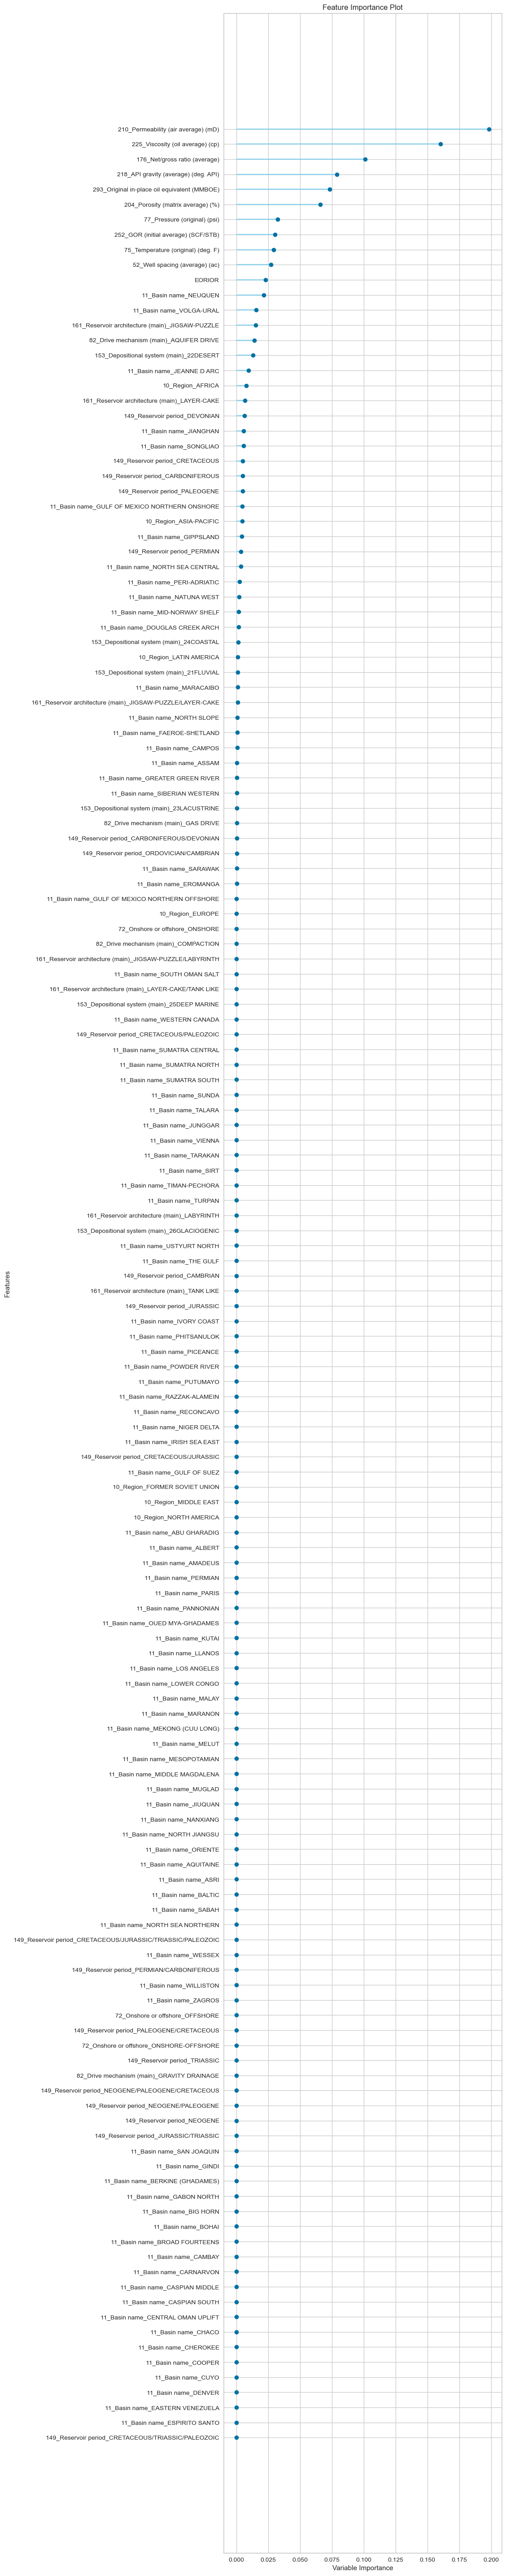

In [24]:
plot_model(gbr, plot = 'feature')

One of the important parameters in the hyperparameters is the number of iterations over which the K fold cross validation is done. 

2 checks are done for this. The first scenario is over the range(0, 1000, 50). The optimisation ran overnight and showed that the ML algorithm did not see much improvement past 50.

In [ ]:
elapsed = []
MAE_mean_iter = []
MSE_mean_iter = []
RMSE_mean_iter = []

# The output from the (0, 1000, 50) is saved; there is no need to run this again. 
# Line has been modified just so the code can run.
for i in range(0, 51, 50):
    start = time.time()
    if i == 0:
        i += 1    
    tuned_cb = tune_model(cb, optimize = 'MSE', n_iter = i)
    #print(tuned_cb)
    MAE_mean_iter.append(pull()['MAE']['Mean'])
    MSE_mean_iter.append(pull()['MSE']['Mean'])
    RMSE_mean_iter.append(pull()['RMSE']['Mean'])
    elapsed.append((time.time() - start))

MAE_Mean = pd.DataFrame(MAE_mean_iter, index = elapsed, columns=['MAE Mean Error'])
MAE_Mean.index.name = 'Elapsed Time'

MSE_Mean = pd.DataFrame(MSE_mean_iter, index = elapsed, columns=['MSE Mean Error']) 
MSE_Mean.index.name = 'Elapsed Time'

RMSE_Mean = pd.DataFrame(RMSE_mean_iter, index = elapsed, columns=['RMSE Mean Error'])
RMSE_Mean.index.name = 'Elapsed Time'

res_50_iter = pd.concat([MAE_Mean, MSE_Mean, RMSE_Mean], axis=1)

print(res_50_iter)

In [ ]:
b = sns.lineplot(data=res_50_iter)
b.axes.set_title("Error as function of Elapsed Time",fontsize=20)
b.set_xlabel("Elapsed Time",fontsize=20)
b.set_ylabel("Error",fontsize=20)
#b.set_yscale('log')
b.tick_params(labelsize=18)

In [ ]:
#res.to_csv('Run_Catboost_1000_Itr.csv')

In [ ]:
elapsed = []
MAE_mean_iter = []
MSE_mean_iter = []
RMSE_mean_iter = []

for i in range(1, 51, 50):
    start = time.time()
    tuned_cb = tune_model(cb, optimize = 'MSE', n_iter = i)
    MAE_mean_iter.append(pull()['MAE']['Mean'])
    MSE_mean_iter.append(pull()['MSE']['Mean'])
    RMSE_mean_iter.append(pull()['RMSE']['Mean'])
    elapsed.append((time.time() - start))

MAE_Mean = pd.DataFrame(MAE_mean_iter, index = elapsed, columns=['MAE Mean Error'])
MAE_Mean.index.name = 'Elapsed Time'

MSE_Mean = pd.DataFrame(MSE_mean_iter, index = elapsed, columns=['MSE Mean Error']) 
MSE_Mean.index.name = 'Elapsed Time'

RMSE_Mean = pd.DataFrame(RMSE_mean_iter, index = elapsed, columns=['RMSE Mean Error'])
RMSE_Mean.index.name = 'Elapsed Time'

res_1_iter = pd.concat([MAE_Mean, MSE_Mean, RMSE_Mean], axis=1)

print(res_1_iter)

res_1_iter.to_csv('Run_Catboost_50_Itr.csv')

In [ ]:
b = sns.lineplot(data=res_1_iter)
b.axes.set_title("Error as function of Elapsed Time",fontsize=20)
b.set_xlabel("Elapsed Time",fontsize=20)
b.set_ylabel("Error",fontsize=20)
#b.set_yscale('log')
b.tick_params(labelsize=18)

In [ ]:
#tuned_cb100 = tune_model(cb, optimize = 'MSE', n_iter = 100)

In [ ]:
#evaluate_model(cb)

#tuned_cb1 = tune_model(cb, search_library = "tune-sklearn", search_algorithm="hyperopt", optimize="MSE", n_iter=10)
#print(tuned_cb1)

#tuned_cb2 = tune_model(cb, search_library = "tune-sklearn", search_algorithm="hyperopt", optimize="RMSE", n_iter=10)
#print(tuned_cb2)

In [ ]:
tuned_cb3 = tune_model(cb, optimize = 'RMSE', n_iter = 50)

In [ ]:
#tuned_cb4 = tune_model(cb, optimize = 'RMSE', n_iter = 10)

In [ ]:
bagged_cb = ensemble_model(cb)

In [ ]:
boosted_cb = ensemble_model(cb, method = 'Boosting')

In [ ]:
#tuned_bagged_cb = tune_model(cb, ensemble = True, method = 'Bagging', n_iter = 100)
#tuned_bagged_cb = tune_model(cb, ensemble = True, method = 'Bagging', n_iter = 100)

### Random Forest

In [ ]:
rf = create_model('rf')
print(rf)

In [ ]:
tuned_rf = tune_model(rf, search_library = "tune-sklearn", search_algorithm="hyperopt", optimize="MSE", n_iter=50)
print(tuned_rf)

In [ ]:
tuned_rf1 = tune_model(rf, search_library = "tune-sklearn", search_algorithm="hyperopt", optimize="RMSE", n_iter=50)
print(tuned_rf1)

In [ ]:
tuned_rf2 = tune_model(rf, optimize="MSE", n_iter=50)
print(tuned_rf2)

In [ ]:
tuned_rf3 = tune_model(rf,optimize="RMSE", n_iter=50)
print(tuned_rf3)

### Gradient Boostsing Regression

In [ ]:
gbr = create_model('gbr')
print(gbr)

In [ ]:
tuned_gbr = tune_model(gbr, search_library = "tune-sklearn", search_algorithm="hyperopt", optimize="MSE", n_iter=50)
print(tuned_gbr)

In [ ]:
tuned_gbr1 = tune_model(gbr, search_library = "tune-sklearn", search_algorithm="hyperopt", optimize="RMSE", n_iter=50)
print(tuned_gbr1)

In [ ]:
tuned_gbr2 = tune_model(gbr, optimize="MSE", n_iter=50)
print(tuned_gbr2)

In [ ]:
tuned_gbr3 = tune_model(gbr, optimize="RMSE", n_iter=50)
print(tuned_gbr3)

In [ ]:
tuned_gbr4 = tune_model(gbr, search_library = "tune-sklearn", search_algorithm="optuna", optimize="RMSE", n_iter=50)
print(tuned_gbr4)

In [ ]:
tuned_gbr5 = tune_model(gbr, search_library = "tune-sklearn", search_algorithm="bayesian", optimize="RMSE", n_iter=50)
print(tuned_gbr5)

### BLENDING ALL MODELS

In [ ]:
blend_all = blend_models(estimator_list = [cb,rf,gbr])

### Stacking Models

In [ ]:
stack_1 = stack_models([cb,rf,gbr], meta_model = cb)

### Save the Model

In [ ]:
save_model(stack_1, 'tuned_gbr_RF')

### The best most is using the GBR Regressor tuned to RMSE using bayesian

In [ ]:
tuned_gbr5

In [ ]:
plot_model(tuned_gbr5)

In [ ]:
plot_model(tuned_gbr5, plot = 'error')

In [ ]:
#https://towardsdatascience.com/easy-mlops-with-pycaret-mlflow-7fbcbf1e38c6
plot_model(tuned_gbr5, plot = 'residuals_interactive')

In [ ]:
plot_model(tuned_gbr5, plot = 'feature')

In [ ]:
plot_model(gbr, plot = 'feature')

In [ ]:
df_drop['EORIOR'].hist()

In [ ]:
df_drop['EORIOR'].describe()

In [ ]:
df_drop['EORIOR'].value_counts()

In [ ]:
df_drop['10_Region'].value_counts()

In [ ]:
df_drop['11_Basin name'].value_counts()

In [ ]:
df_drop['11_Basin name'].nunique()

In [ ]:
df_drop['82_Drive mechanism (main)'].value_counts()

In [ ]:
df_drop['149_Reservoir period'].value_counts()

In [ ]:
df_drop['153_Depositional system (main)'].value_counts()

In [ ]:
df_drop['161_Reservoir architecture (main)'].value_counts()

In [ ]:
df_drop['EORIOR'].value_counts()

In [ ]:
dfblind = pd.read_excel("BlindTest_SSOIL.xlsx", thousands=',', skiprows = skiprows)
#dfblind = dfblind.loc[:, ~df.columns.str.contains('^Unnamed')] 
dfblind.head()

In [ ]:
BlindPredict = predict_model(tuned_gbr5, data=dfblind, round=0)

In [ ]:
BlindPredict